### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from io import BytesIO
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import re
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

In [3]:
dfDresses = pd.read_csv('/content/drive/MyDrive/Datasets/dfDresses.csv')

### Data Processing

In [ ]:
dfDresses

In [5]:
dfDresses.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'dresses-link',
       'dresses-link-href', 'dresses-image-url-src', 'dresses-price',
       'dresses-desc', 'dresses-detail', 'dresses-sleeve-length',
       'dresses-neck', 'dresses-type', 'dresses-print', 'dresses-sleeve-style',
       'dresses-surface', 'dresses-trans', 'dresses-length', 'dresses-fabric',
       'dresses-trend', 'dresses-occasion', 'dresses-weave-type',
       'dresses-rating', 'dresses-num-ratings', 'dresses-5stars',
       'dresses-4stars', 'dresses-3stars', 'dresses-2stars', 'dresses-1stars',
       'is-top'],
      dtype='object')

In [6]:
columns_to_drop = ["web-scraper-order", "web-scraper-start-url", "dresses-link-href",'dresses-desc', 'dresses-detail', 'dresses-neck','dresses-surface', 'dresses-trans', 'dresses-length', 'dresses-fabric',
       'dresses-trend', 'dresses-occasion', 'dresses-weave-type']
dfDressesClean = dfDresses.drop(columns=columns_to_drop)
dfDressesClean.rename(columns={"dresses-link": "dresses-name"}, inplace=True)

In [7]:
dfDressesClean.head()

,dresses-name,dresses-image-url-src,dresses-price,dresses-sleeve-length,dresses-type,dresses-print,dresses-sleeve-style,dresses-rating,dresses-num-ratings,dresses-5stars,dresses-4stars,dresses-3stars,dresses-2stars,dresses-1stars,is-top
0,NayoEthnic Motifs A-Line Maxi DressSizes: MRs....,NaN,₹999,NaN,NaN,NaN,NaN,4.1,508 Ratings,274.0,116.0,52.0,26.0,40.0,NaN
1,NayoEthnic Motifs A-Line Maxi DressSizes: MRs....,"https://assets.myntassets.com/h_68,q_90,w_52/v...",₹999,NaN,NaN,NaN,NaN,4.1,508 Ratings,274.0,116.0,52.0,26.0,40.0,0.0
2,NayoEthnic Motifs A-Line Maxi DressSizes: MRs....,NaN,₹999,Cotton,Flared,Woven,Maxi,4.1,508 Ratings,274.0,116.0,52.0,26.0,40.0,0.0
3,NayoEthnic Motifs A-Line Maxi DressSizes: MRs....,NaN,₹999,Cotton,Flared,Woven,Maxi,4.1,508 Ratings,274.0,116.0,52.0,26.0,40.0,0.0
4,DEKLOOKAccordian Pleats A-Line DressSizes: SRs...,NaN,₹579,NaN,NaN,NaN,NaN,3.8,96 Ratings,46.0,23.0,7.0,2.0,18.0,0.0


In [8]:
dfDressesClean["dresses-num-ratings"] = dfDressesClean["dresses-num-ratings"].str.replace(" Ratings", "")

dfDressesClean["dresses-num-ratings"] = dfDressesClean["dresses-num-ratings"].str.replace("k", "e3")

dfDressesClean["dresses-num-ratings"] = pd.to_numeric(dfDressesClean["dresses-num-ratings"])

In [ ]:
dfDressesClean["dresses-price"] = dfDressesClean["dresses-price"].str.replace("Rs.", "")
dfDressesClean["dresses-price"] = dfDressesClean["dresses-price"].str.replace("₹", "")

dfDressesClean["dresses-num-ratings"] = pd.to_numeric(dfDressesClean["dresses-num-ratings"])
dfDressesClean["dresses-price"] = pd.to_numeric(dfDressesClean["dresses-price"])

In [10]:
min_price = dfDressesClean["dresses-price"].min()
max_price = dfDressesClean["dresses-price"].max()
dfDressesClean["normalized-dresses-price"] = (dfDressesClean["dresses-price"] - min_price) / (max_price - min_price)

In [11]:
dfDressesClean = dfDressesClean[dfDressesClean["dresses-price"] != 0]

In [ ]:
dfDressesClean["dresses-image-url-src"] = dfDressesClean["dresses-image-url-src"].str.replace("3.jpg", "1.jpg")

In [13]:
dfDressesClean.dropna(subset=["dresses-num-ratings"], inplace=True)

dfDressesClean.reset_index(drop=True, inplace=True)

In [14]:
# process consecutive groups of entries with the same price
row = 0
while row < len(dfDressesClean) - 4:
    if (dfDressesClean.at[row, "dresses-price"] == dfDressesClean.at[row + 1, "dresses-price"] ==
        dfDressesClean.at[row + 2, "dresses-price"] == dfDressesClean.at[row + 3, "dresses-price"] and
        dfDressesClean.at[row, "dresses-price"] != dfDressesClean.at[row + 4, "dresses-price"]):

        url_to_copy = dfDressesClean.at[row + 1, "dresses-image-url-src"]
        dfDressesClean.at[row + 3, "dresses-image-url-src"] = url_to_copy

        dfDressesClean.drop([row, row + 1, row + 2], inplace=True)
        dfDressesClean.reset_index(drop=True, inplace=True)

    elif (dfDressesClean.at[row, "dresses-price"] == dfDressesClean.at[row + 1, "dresses-price"] ==
          dfDressesClean.at[row + 2, "dresses-price"] == dfDressesClean.at[row + 3, "dresses-price"] ==
          dfDressesClean.at[row + 4, "dresses-price"]):

        url_to_copy = dfDressesClean.at[row + 1, "dresses-image-url-src"]
        dfDressesClean.at[row + 3, "dresses-image-url-src"] = url_to_copy

        dfDressesClean.drop([row, row + 1, row + 2, row + 4], inplace=True)
        dfDressesClean.reset_index(drop=True, inplace=True)

    else:
        row += 1

    row += 1

In [15]:
# edge-case
if pd.isnull(dfDressesClean.at[len(dfDressesClean) - 1, "dresses-image-url-src"]):
    url_to_copy = dfDressesClean.at[len(dfDressesClean) - 3, "dresses-image-url-src"]
    dfDressesClean.at[len(dfDressesClean) - 1, "dresses-image-url-src"] = url_to_copy

dfDressesClean.drop([len(dfDressesClean) - 2, len(dfDressesClean) - 3, len(dfDressesClean) - 4], inplace=True)
dfDressesClean.reset_index(drop=True, inplace=True)

In [16]:
def is_valid_url(url):
    try:
        response = requests.get(url)
        return response.status_code == 200  # 200 means ok response
    except:
        return False

dfDressesClean = dfDressesClean[dfDressesClean["dresses-image-url-src"].apply(is_valid_url)]
dfDressesClean.reset_index(drop=True, inplace=True)

In [ ]:
# magnify the image's dimensions
dfDressesClean["dresses-image-url-src"] = dfDressesClean["dresses-image-url-src"].str.replace("h_68,q_90,w_52", "h_168,q_190,w_152")
dfDressesClean.reset_index(drop=True, inplace=True)

In [ ]:
dfDressesClean.dropna(subset=["dresses-5stars"], inplace=True)
dfDressesClean.reset_index(drop=True, inplace=True)

In [ ]:
def calculate_popularity_score(row):
    num_ratings = row['dresses-num-ratings']
    stars_5 = row['dresses-5stars']
    stars_4 = row['dresses-4stars']
    stars_3 = row['dresses-3stars']
    stars_2 = row['dresses-2stars']
    stars_1 = row['dresses-1stars']
    normalized_price = row['normalized-dresses-price']

    satisfaction_ratio = (stars_5 + stars_4) / num_ratings if num_ratings > 0 else 0
    total_stars = stars_5 + stars_4 + stars_3 + stars_2 + stars_1
    popularity_score = 0

    if num_ratings >= 1000 and satisfaction_ratio >= 0.8:
        popularity_score = 2  # highly pop n satis
    elif num_ratings >= 1000 and satisfaction_ratio >= 0.6:
        popularity_score = 1  # highly pop but less satis
    elif num_ratings >= 500 and satisfaction_ratio >= 0.8:
        popularity_score = 2  # less pop but satis
    elif num_ratings >= 500 and satisfaction_ratio >= 0.6:
        popularity_score = 1  # both less

    if normalized_price < 0.5: # if price is low people will buy it
        popularity_score += 1  # lower price boosts popularity score by 1

    return popularity_score

dfDressesClean['popularity_score'] = dfDressesClean.apply(calculate_popularity_score, axis=1)

In [21]:
dfDressesClean= dfDressesClean.replace("nan", "")
dfDressesClean.dropna(inplace=True)
dfDressesClean.reset_index(drop=True, inplace=True)
dfDressesClean.dropna(how='any', inplace=True)
dfDressesClean.reset_index(drop=True, inplace=True)

In [22]:
dfDressesClean.columns

Index(['dresses-name', 'dresses-image-url-src', 'dresses-price',
       'dresses-sleeve-length', 'dresses-type', 'dresses-print',
       'dresses-sleeve-style', 'dresses-rating', 'dresses-num-ratings',
       'dresses-5stars', 'dresses-4stars', 'dresses-3stars', 'dresses-2stars',
       'dresses-1stars', 'is-top', 'normalized-dresses-price',
       'popularity_score'],
      dtype='object')

### EDA

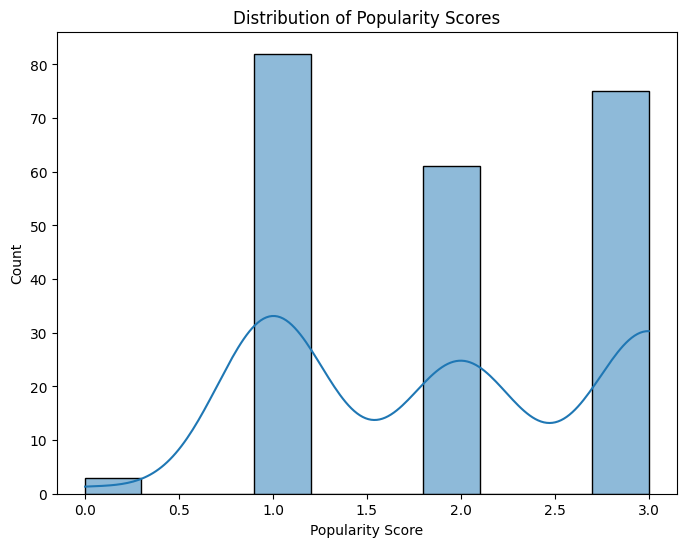

In [23]:
import seaborn as sns
# distribution of popularity scores

plt.figure(figsize=(8, 6))
sns.histplot(dfDressesClean['popularity_score'], bins=10, kde=True)
plt.xlabel('Popularity Score')
plt.ylabel('Count')
plt.title('Distribution of Popularity Scores')
plt.show()

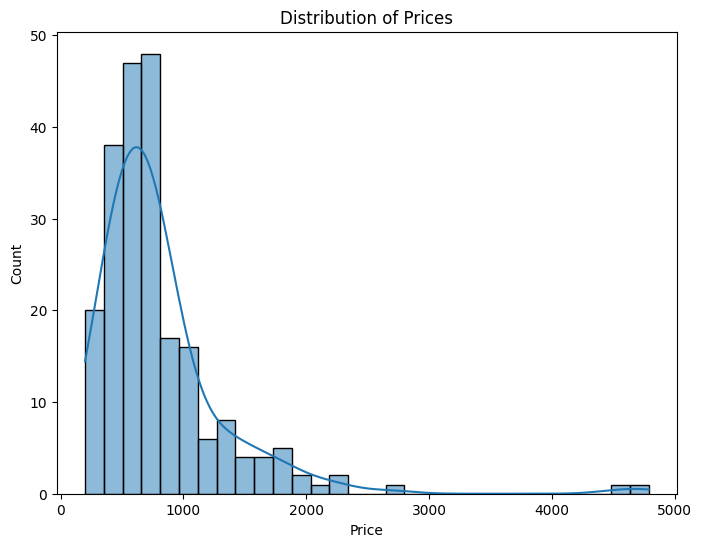

In [24]:
# distribution of prices
plt.figure(figsize=(8, 6))
sns.histplot(dfDressesClean['dresses-price'], bins=30, kde=True)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of Prices')
plt.show()

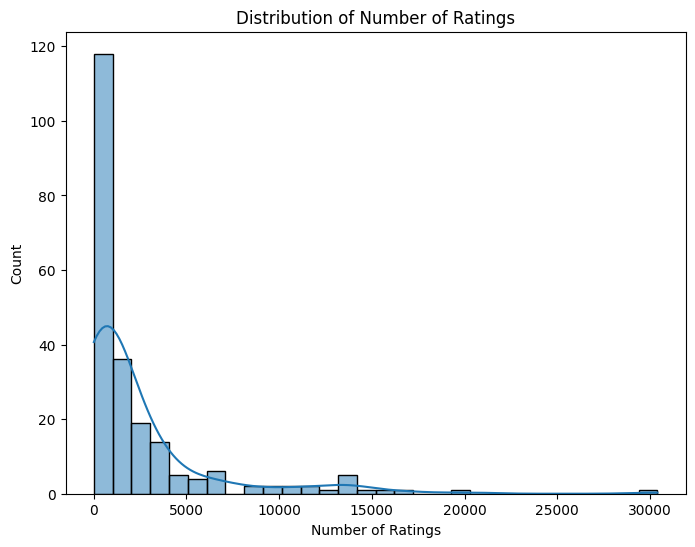

In [25]:
# distribution of number of ratings
plt.figure(figsize=(8, 6))
sns.histplot(dfDressesClean['dresses-num-ratings'], bins=30, kde=True)
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.title('Distribution of Number of Ratings')
plt.show()

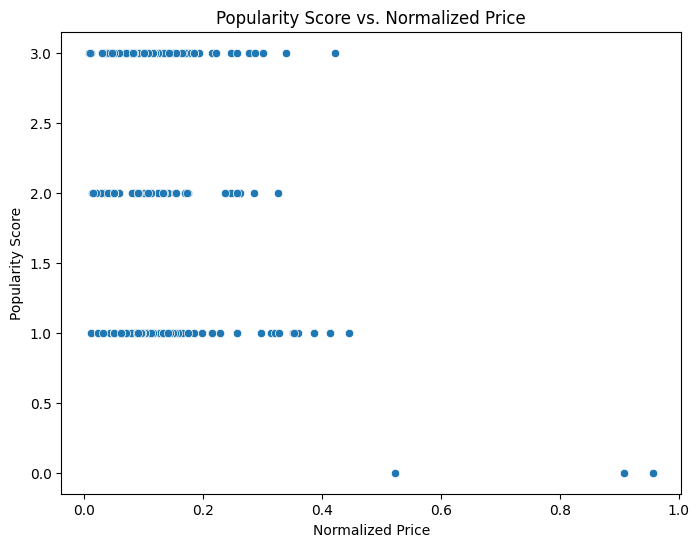

In [26]:
# popularity score vs price
plt.figure(figsize=(8, 6))
sns.scatterplot(x='normalized-dresses-price', y='popularity_score', data=dfDressesClean)
plt.xlabel('Normalized Price')
plt.ylabel('Popularity Score')
plt.title('Popularity Score vs. Normalized Price')
plt.show()


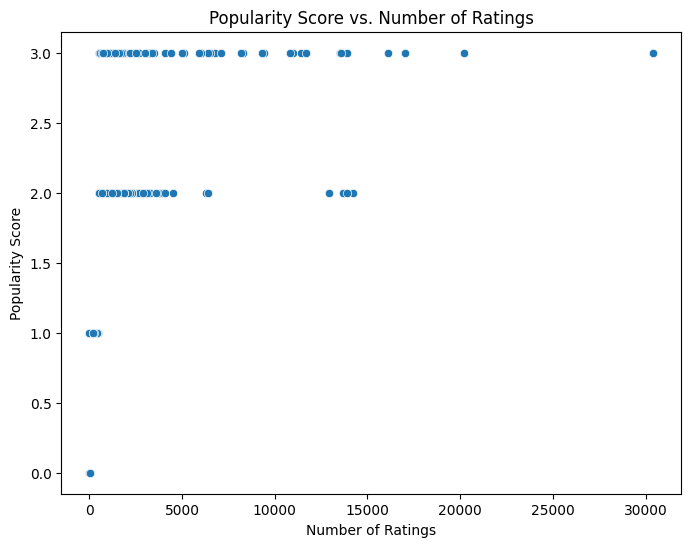

In [27]:
# popularity score vs number of ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dresses-num-ratings', y='popularity_score', data=dfDressesClean)
plt.xlabel('Number of Ratings')
plt.ylabel('Popularity Score')
plt.title('Popularity Score vs. Number of Ratings')
plt.show()


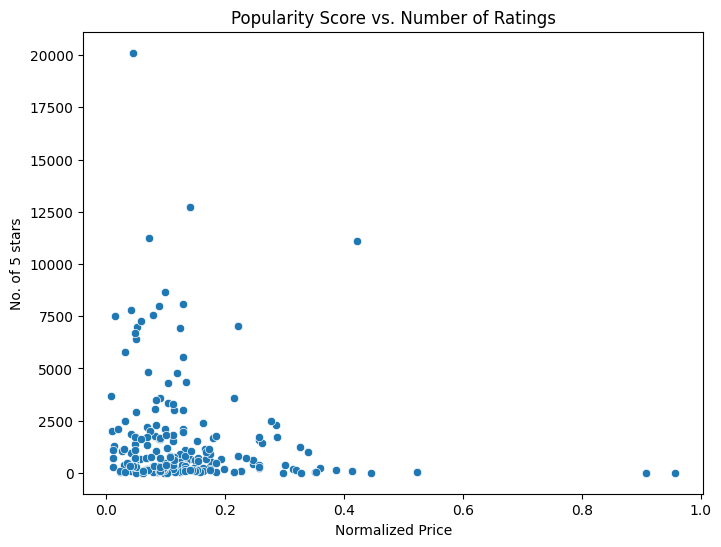

In [28]:
# popularity score vs number of 5 star ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x='normalized-dresses-price', y='dresses-5stars', data=dfDressesClean)
plt.xlabel('Normalized Price')
plt.ylabel('No. of 5 stars')
plt.title('Popularity Score vs. Number of Ratings')
plt.show()


### Machine Learning (Image Classification Model)

In [29]:
columns_to_encode = ['dresses-sleeve-length', 'dresses-type', 'dresses-sleeve-style',
                      'dresses-print']

df_to_encode = dfDressesClean[columns_to_encode]
one_hot_encoded = pd.get_dummies(df_to_encode, dummy_na=True)

dfDressesClean_encoded = pd.concat([dfDressesClean.drop(columns=columns_to_encode), one_hot_encoded], axis=1) # join both
dfDressesCleanOG = dfDressesClean
dfDressesClean = dfDressesClean_encoded

In [30]:
column_names = dfDressesClean.columns.tolist()
print((column_names))

['dresses-name', 'dresses-image-url-src', 'dresses-price', 'dresses-rating', 'dresses-num-ratings', 'dresses-5stars', 'dresses-4stars', 'dresses-3stars', 'dresses-2stars', 'dresses-1stars', 'is-top', 'normalized-dresses-price', 'popularity_score', 'dresses-sleeve-length_A-Line', 'dresses-sleeve-length_Blazer Dresses', 'dresses-sleeve-length_Bodycon', 'dresses-sleeve-length_Comes with a belt', 'dresses-sleeve-length_Cotton', 'dresses-sleeve-length_Empire', 'dresses-sleeve-length_Fit and Flare', 'dresses-sleeve-length_Gown', 'dresses-sleeve-length_Hook and Eye', 'dresses-sleeve-length_Long Sleeves', 'dresses-sleeve-length_Maxi', 'dresses-sleeve-length_Sheath', 'dresses-sleeve-length_Shirt', 'dresses-sleeve-length_Short Sleeves', 'dresses-sleeve-length_Sleeveless', 'dresses-sleeve-length_T-shirt', 'dresses-sleeve-length_Three-Quarter Sleeves', 'dresses-sleeve-length_Viscose Rayon', 'dresses-sleeve-length_Wrap', 'dresses-sleeve-length_nan', 'dresses-type_A-Line', 'dresses-type_Above Knee',

In [31]:
style_columns = ['is-top','dresses-sleeve-length_A-Line', 'dresses-sleeve-length_Blazer Dresses', 'dresses-sleeve-length_Bodycon', 'dresses-sleeve-length_Comes with a belt', 'dresses-sleeve-length_Cotton', 'dresses-sleeve-length_Empire', 'dresses-sleeve-length_Fit and Flare', 'dresses-sleeve-length_Gown', 'dresses-sleeve-length_Hook and Eye', 'dresses-sleeve-length_Maxi', 'dresses-sleeve-length_Sheath', 'dresses-sleeve-length_Shirt', 'dresses-sleeve-length_T-shirt', 'dresses-sleeve-length_Viscose Rayon', 'dresses-sleeve-length_Wrap', 'dresses-sleeve-length_nan', 'dresses-type_Above Knee', 'dresses-type_Cotton', 'dresses-type_Flared', 'dresses-type_Knee Length', 'dresses-type_Maxi', 'dresses-type_Midi', 'dresses-type_Mini', 'dresses-type_Solid', 'dresses-type_Woven', 'dresses-type_nan', 'dresses-sleeve-style_Ethnic Print', 'dresses-sleeve-style_Flared', 'dresses-sleeve-style_Floral', 'dresses-sleeve-style_Long Sleeves', 'dresses-sleeve-style_Maxi', 'dresses-sleeve-style_Midi', 'dresses-sleeve-style_No Sleeves', 'dresses-sleeve-style_Short Sleeves', 'dresses-sleeve-style_Sleeveless', 'dresses-sleeve-style_Three-Quarter Sleeves', 'dresses-sleeve-style_Tiered', 'dresses-sleeve-style_Tropical', 'dresses-sleeve-style_Woven', 'dresses-sleeve-style_nan', 'dresses-print_Above Knee', 'dresses-print_Cotton', 'dresses-print_Ethnic Motifs', 'dresses-print_Flared', 'dresses-print_Floral', 'dresses-print_Geometric', 'dresses-print_Graphic', 'dresses-print_Maxi', 'dresses-print_Midi', 'dresses-print_Self Design', 'dresses-print_Sleeveless', 'dresses-print_Solid', 'dresses-print_Striped', 'dresses-print_Woven', 'dresses-print_nan']

dfStyle = dfDressesClean[style_columns]

In [32]:
dfStyle.head()

,is-top,dresses-sleeve-length_A-Line,dresses-sleeve-length_Blazer Dresses,dresses-sleeve-length_Bodycon,dresses-sleeve-length_Comes with a belt,dresses-sleeve-length_Cotton,dresses-sleeve-length_Empire,dresses-sleeve-length_Fit and Flare,dresses-sleeve-length_Gown,dresses-sleeve-length_Hook and Eye,...,dresses-print_Geometric,dresses-print_Graphic,dresses-print_Maxi,dresses-print_Midi,dresses-print_Self Design,dresses-print_Sleeveless,dresses-print_Solid,dresses-print_Striped,dresses-print_Woven,dresses-print_nan
0,0.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [33]:
def load_and_preprocess_image(url, target_size=(224, 224)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)
    img = np.array(img) / 255.0  # normalize pixel values
    return img

In [34]:
X_images = np.array([load_and_preprocess_image(url) for url in dfDressesClean['dresses-image-url-src']])
y_style = dfDressesClean[style_columns].values

In [35]:
num_style_classes = dfStyle.shape[1] # no. of classes for style label classif.

y_style_encoded = tf.keras.utils.to_categorical(y_style, num_classes=num_style_classes)
# one hot encode style labels

In [36]:
X_train, X_val, y_style_train, y_style_val = train_test_split(X_images, y_style, test_size=0.2, random_state=42)

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
) # data augmentation

def apply_data_augmentation(X): # X is input, we will apply to input
    augmented_images = []
    for img in X:
        img_augmented = datagen.random_transform(img)
        augmented_images.append(img_augmented)
    return np.array(augmented_images)

X_train_augmented = apply_data_augmentation(X_train)

X_train_combined = np.concatenate((X_train, X_train_augmented)) # join
y_style_train_combined = np.concatenate((y_style_train, y_style_train))

combined_indices = np.arange(X_train_combined.shape[0]) # shuffle
np.random.shuffle(combined_indices)
X_train_combined = X_train_combined[combined_indices]
y_style_train_combined = y_style_train_combined[combined_indices]

In [38]:
#!pip install --upgrade tensorflow

In [73]:
from tensorflow.keras.applications import ResNet50
# resnet50 is not good for this project
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [74]:
from tensorflow.keras.layers import BatchNormalization

x = GlobalAveragePooling2D()(base_model.output)
style_output = Dense(512, activation='relu')(x)
style_output = BatchNormalization()(style_output)
style_output = Dense(num_style_classes, activation='sigmoid', name='style_output')(style_output) # sigmoid is good for bin. values not softmax

In [75]:
model = Model(inputs=base_model.input, outputs=[style_output])

In [76]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import *

def lr_schedule(epoch):
    initial_lr = 0.0001
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr * np.exp(0.1 * (5 - epoch))

lr_scheduler = LearningRateScheduler(lr_schedule)

from tensorflow.keras.regularizers import l2

l2_reg = 0.001

style_output = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
style_output = BatchNormalization()(style_output)
# style_output = Dropout(0.5)(style_output)
style_output = Dense(num_style_classes, activation='sigmoid', name='style_output', kernel_regularizer=l2(l2_reg))(style_output)

In [77]:
model = Model(inputs=base_model.input, outputs=[style_output])

In [78]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'style_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

In [79]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [80]:
history = model.fit(
    X_train,
    {'style_output': y_style_train},
    validation_data=(X_val, {'style_output': y_style_val}),
    epochs=10,
    batch_size=16,
    verbose=1
)

Epoch 1/10
11/11 [==============================] - 35s 237ms/step - loss: 14.6899 - accuracy: 0.0511 - val_loss: 12.7387 - val_accuracy: 0.0000e+00
Epoch 2/10
11/11 [==============================] - 1s 84ms/step - loss: 10.7896 - accuracy: 0.2443 - val_loss: 12.2344 - val_accuracy: 0.0889
Epoch 3/10
11/11 [==============================] - 1s 89ms/step - loss: 8.9628 - accuracy: 0.4205 - val_loss: 11.8134 - val_accuracy: 0.1333
Epoch 4/10
11/11 [==============================] - 1s 80ms/step - loss: 7.7798 - accuracy: 0.3523 - val_loss: 11.6108 - val_accuracy: 0.2889
Epoch 5/10
11/11 [==============================] - 1s 86ms/step - loss: 7.1100 - accuracy: 0.3807 - val_loss: 11.5454 - val_accuracy: 0.2889
Epoch 6/10
11/11 [==============================] - 1s 86ms/step - loss: 7.1645 - accuracy: 0.3693 - val_loss: 11.6867 - val_accuracy: 0.3111
Epoch 7/10
11/11 [==============================] - 1s 86ms/step - loss: 6.8218 - accuracy: 0.3920 - val_loss: 11.8942 - val_accuracy: 0.333

### Visualisation

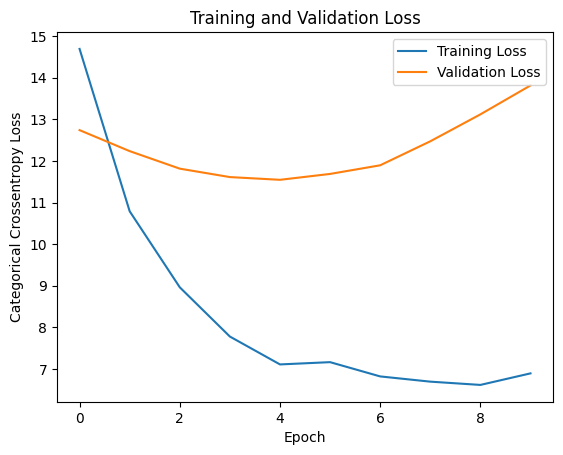

In [82]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step


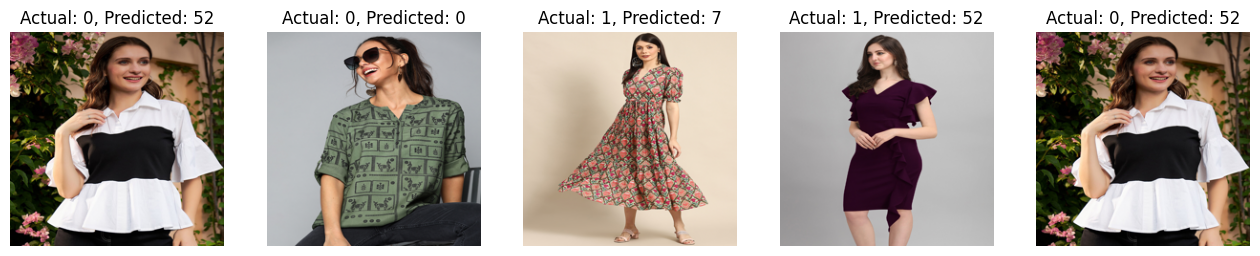

In [83]:
sample_indices = np.random.randint(0, len(X_val), size=5)
sample_images = X_val[sample_indices]
sample_predictions = model.predict(sample_images)

sample_predicted_labels = np.argmax(sample_predictions, axis=1)
sample_actual_labels = np.argmax(y_style_val[sample_indices], axis=1) # convert one hot back

plt.figure(figsize=(16, 10))
for i, img in enumerate(sample_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {sample_actual_labels[i]}, Predicted: {sample_predicted_labels[i]}")
    plt.axis('off')
plt.show()

2/2 [==============================] - 1s 16ms/step


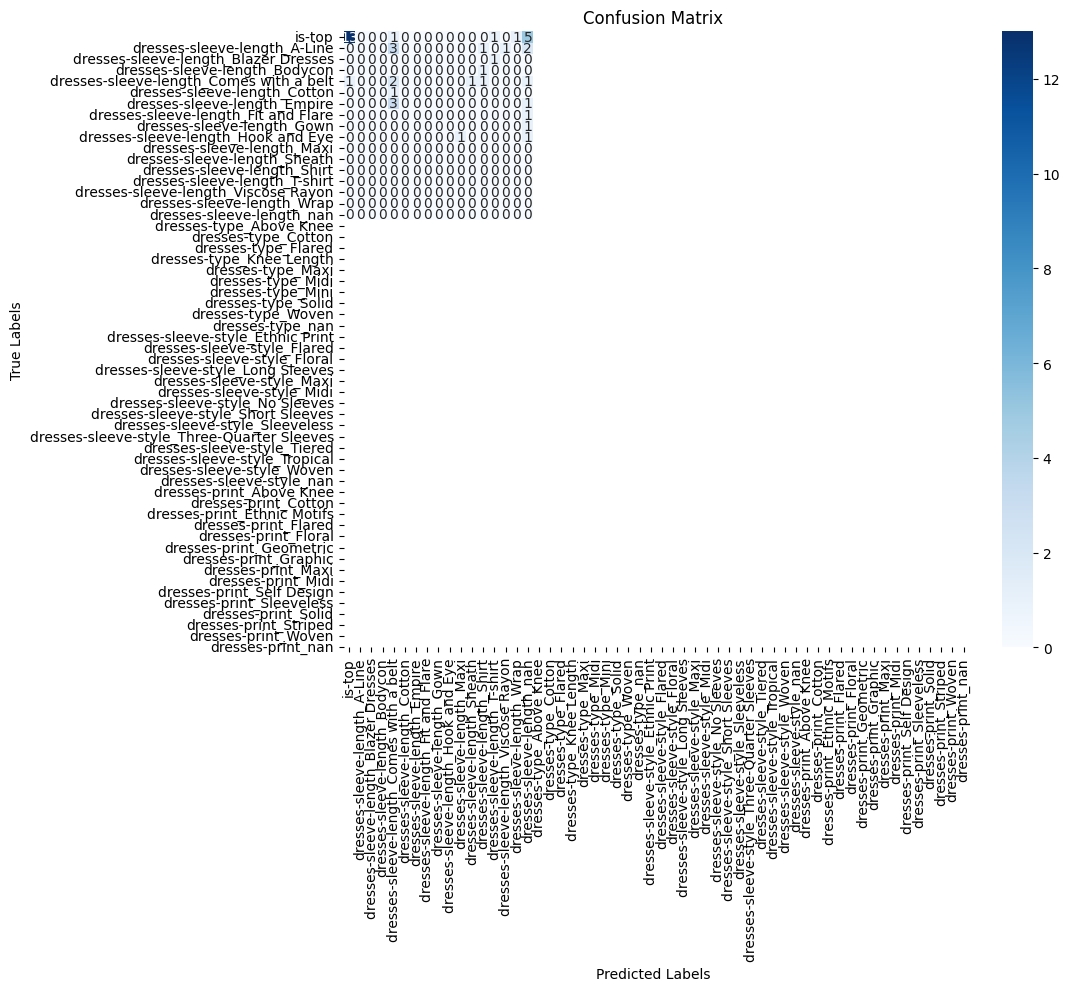

In [84]:
from sklearn.metrics import confusion_matrix

# pred entire val set
val_predictions = model.predict(X_val)
val_predicted_labels = np.argmax(val_predictions, axis=1)
val_actual_labels = np.argmax(y_style_val, axis=1)

cm = confusion_matrix(val_actual_labels, val_predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=style_columns, yticklabels=style_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Machine Learning (Regression Model)

In [85]:
def load_and_preprocess_image(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = image.resize((224, 224))
    image_array = np.array(image)
    image_array = tf.keras.applications.mobilenet_v2.preprocess_input(image_array)
    return image_array

In [86]:
image_data = dfDressesClean['dresses-image-url-src'].apply(load_and_preprocess_image).values

In [87]:
image_data = np.array(list(image_data))

In [88]:
X_image = image_data
X_style = dfDressesClean.drop(columns=['dresses-image-url-src', 'dresses-name', 'popularity_score']).values
y = dfDressesClean['popularity_score'].values

In [372]:
X_image_train, X_image_test, X_style_train, X_style_test, y_train, y_test = train_test_split(
    X_image, X_style, y, test_size=0.2, random_state=42
)

In [373]:
popularity_scaler = MinMaxScaler()
y_train_normalized = popularity_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_normalized = popularity_scaler.transform(y_test.reshape(-1, 1)) # normalise pop scores too (model seems to work better when i do this)

In [374]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [375]:
from tensorflow.keras.layers import *

base_model.trainable = False

input_image = Input(shape=(224, 224, 3))

x = base_model(input_image)

x = GlobalAveragePooling2D()(x)

input_style = Input(shape=(X_style.shape[1],))

combined_input = tf.keras.layers.concatenate([x, input_style])

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(1)(x)
# output = single unit = pop score prediction

In [376]:
model = Model(inputs=[input_image, input_style], outputs=output)

In [ ]:
model.compile(loss='mse', optimizer=Adam(lr=1e-4))

In [378]:
# model.summary()

In [379]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [380]:
epochs = 20
batch_size = 16

datagen.fit(X_image_train) #augmen

augmented_train_gen = datagen.flow([X_image_train, X_style_train], y_train, batch_size=batch_size)

history = model.fit(
    augmented_train_gen,
    steps_per_epoch=len(X_image_train) // batch_size,
    validation_data=([X_image_test, X_style_test], y_test_normalized),
    epochs=epochs
)

Epoch 1/20
11/11 [==============================] - 6s 280ms/step - loss: 3.5054 - val_loss: 2.5981
Epoch 2/20
11/11 [==============================] - 3s 294ms/step - loss: 1.4719 - val_loss: 1.4836
Epoch 3/20
11/11 [==============================] - 2s 196ms/step - loss: 0.9838 - val_loss: 1.7765
Epoch 4/20
11/11 [==============================] - 2s 194ms/step - loss: 0.8753 - val_loss: 0.6638
Epoch 5/20
11/11 [==============================] - 2s 202ms/step - loss: 0.9058 - val_loss: 2.1514
Epoch 6/20
11/11 [==============================] - 2s 196ms/step - loss: 0.7662 - val_loss: 1.2240
Epoch 7/20
11/11 [==============================] - 4s 368ms/step - loss: 0.7670 - val_loss: 1.4910
Epoch 8/20
11/11 [==============================] - 2s 203ms/step - loss: 0.6801 - val_loss: 1.1346
Epoch 9/20
11/11 [==============================] - 2s 196ms/step - loss: 0.6599 - val_loss: 1.8800
Epoch 10/20
11/11 [==============================] - 2s 196ms/step - loss: 0.6991 - val_loss: 1.1744

### Visualisation

In [381]:
y_pred = model.predict([X_image_test, X_style_test]).flatten()
# pred test data

2/2 [==============================] - 1s 45ms/step


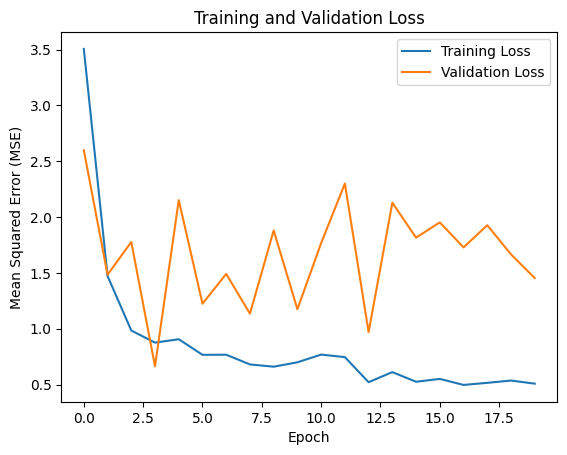

In [382]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

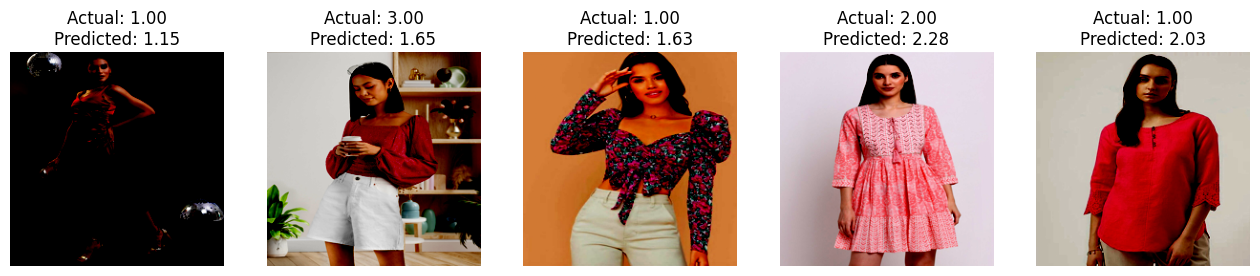

In [390]:
# random test samp
sample_indices = np.random.randint(0, len(X_image_test), size=5)
sample_images = X_image_test[sample_indices]
sample_styles = X_style_test[sample_indices]
sample_actual_scores = y_test[sample_indices]
sample_predicted_scores = y_pred[sample_indices]

plt.figure(figsize=(16, 10))
for i, (img, style, actual_score, predicted_score) in enumerate(zip(sample_images, sample_styles, sample_actual_scores, sample_predicted_scores)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {actual_score:.2f}\nPredicted: {predicted_score:.2f}")
    plt.axis('off')
plt.show()

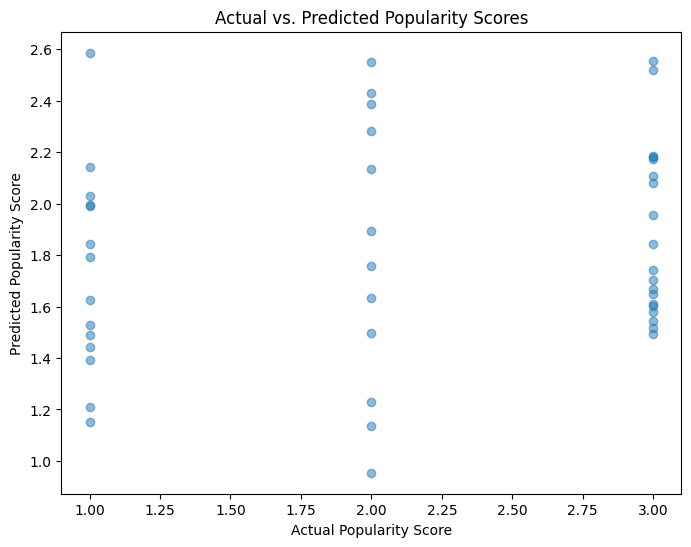

In [384]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Popularity Score')
plt.ylabel('Predicted Popularity Score')
plt.title('Actual vs. Predicted Popularity Scores')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [389]:
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 0.7867
R-squared (R2): 0.0979
